## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import qmc
import random
import math

# Set global parameters to ensure font size is 12pt
matplotlib.rcParams.update({
    'font.size': 12,  # Adjust font size
    'figure.dpi': 300  # Remove this if not using the plot for a report
})

seed = 42
random.seed(seed)
np.random.seed(seed)

## Basic Fully-Connected Network

In [2]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        activation = nn.Tanh

        # Input layer
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())

        # Hidden layers
        hidden_layers = [nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS-1)]
        self.fch = nn.Sequential(*hidden_layers)

        # Output layer
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        for hidden_layer in self.fch:
            x = hidden_layer(x)
        x = self.fce(x)
        return x

# Example usage
N_INPUT = 2
N_OUTPUT = 1
N_HIDDEN = 20
N_LAYERS = 5
pinn = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

## Xavier Initialisation

In [3]:
def init_xavier(model, retrain_seed=42):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

init_xavier(pinn, seed)

In [4]:
# Constants definition
X, T, v = 1.0, 0.5, 2.0
N = 2500

N_sqrt = int(N**0.5)  # To create a square grid for simplicity
resolution = X/N_sqrt
epsilon = (3/2)*resolution

# Generate a grid of points within the domain
t_values = torch.linspace(0, T, N_sqrt).view(-1, 1)
x_values = torch.linspace(0, X, N_sqrt).view(-1, 1)
t_grid, x_grid = torch.meshgrid(t_values[:, 0], x_values[:, 0], indexing='ij')

# Flatten the grid to pass through the network
t_physics = t_grid.reshape(-1, 1).requires_grad_(True)
x_physics = x_grid.reshape(-1, 1).requires_grad_(True)

# Boundary and initial condition points
t_initial = torch.zeros(N_sqrt, 1).requires_grad_(True)
x_initial = torch.linspace(0, X, N_sqrt).view(-1, 1).requires_grad_(True)

# Initialize a dictionary to store the individual loss components
loss_history = {'total_loss': [], 'ic_loss': [], 'level_set_loss': [], 'eikonal_loss': []}

for iteration in range(10000):
    optimiser.zero_grad()

    # Compute phi IC loss
    combined_input = torch.cat([t_initial, x_initial], dim=1)
    phi = pinn(combined_input)

    ic_loss = torch.mean((phi - x_initial)**2)

    # Compute physics loss
    combined_input = torch.cat([t_physics, x_physics], dim=1)
    phi = pinn(combined_input)
    phi_t = torch.autograd.grad(phi, t_physics, torch.ones_like(phi), create_graph=True)[0]
    phi_x = torch.autograd.grad(phi, x_physics, torch.ones_like(phi), create_graph=True)[0]

    level_set_loss = torch.mean((phi_t + v*phi_x)**2)
    eikonal_loss = torch.mean((phi_x.abs() - 1)**2)

    total_loss = ic_loss + level_set_loss + eikonal_loss
    total_loss.backward()
    optimiser.step()

    loss_history['total_loss'].append(total_loss.item())
    loss_history['ic_loss'].append(ic_loss.item())
    loss_history['level_set_loss'].append(level_set_loss.item())
    loss_history['eikonal_loss'].append(eikonal_loss.item())

    # Record losses every few iterations
    if iteration % 500 == 0:
        print(f"Iteration {iteration}, Total: {total_loss.item()}, IC: {ic_loss.item()}, Level-set: {level_set_loss.item()}, Eikonal: {eikonal_loss.item()}")

Iteration 0, Total: 18.76288604736328, IC: 0.24800123274326324, Level-set: 18.29994773864746, Eikonal: 0.2149377465248108
Iteration 500, Total: 0.0038889674469828606, IC: 4.780002564075403e-05, Level-set: 0.00234704976901412, Eikonal: 0.001494117546826601
Iteration 1000, Total: 0.000916231656447053, IC: 8.63913373905234e-06, Level-set: 0.0005328493425622582, Eikonal: 0.00037474316195584834
Iteration 1500, Total: 0.0003731963806785643, IC: 2.517473376428825e-06, Level-set: 0.00024035084061324596, Eikonal: 0.0001303280732827261
Iteration 2000, Total: 0.00021385336003731936, IC: 1.2426079365468468e-06, Level-set: 0.0001435696758562699, Eikonal: 6.904108158778399e-05
Iteration 2500, Total: 0.0001503000530647114, IC: 9.369497320221853e-07, Level-set: 9.850440255831927e-05, Eikonal: 5.085869997856207e-05
Iteration 3000, Total: 0.00011215780978091061, IC: 7.898054263932863e-07, Level-set: 7.018906762823462e-05, Eikonal: 4.1178936953656375e-05
Iteration 3500, Total: 8.477723167743534e-05, IC: 

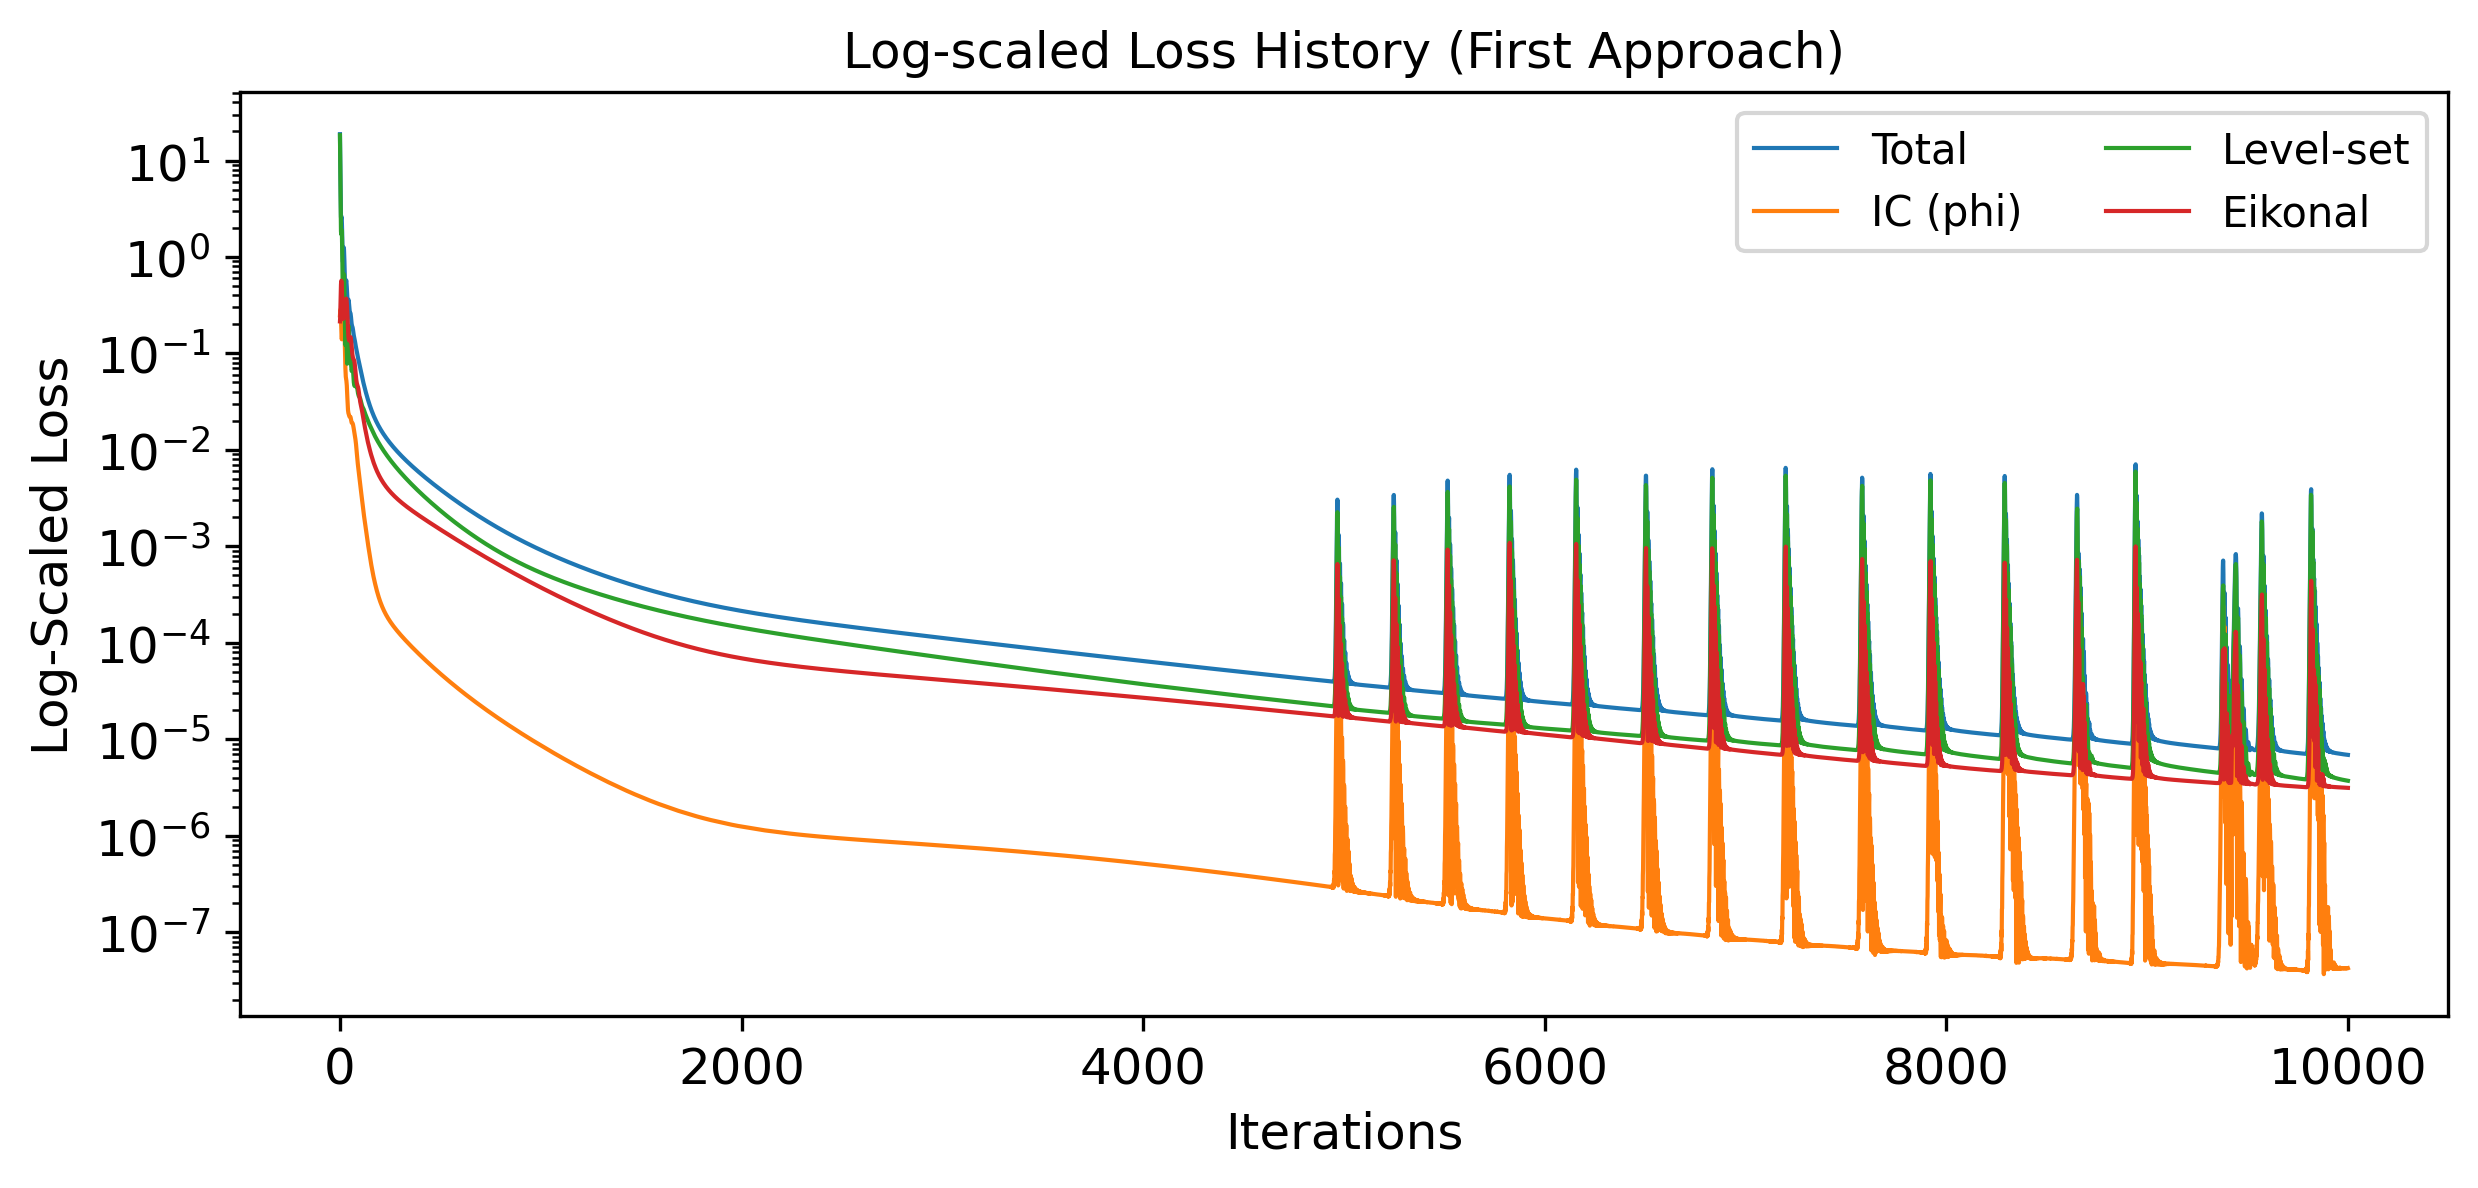

In [5]:
# Define a variable for line width
line_width = 1

# Create a plot with adjusted dimensions
fig, ax = plt.subplots(figsize=(9.5, 4))  # Width in inches to fit A4 page with 20mm margins, height adjusted as needed

# Plot each component of the loss with a logarithmic scale using the line width variable
ax.semilogy(loss_history['total_loss'], label='Total', linewidth=line_width)
ax.semilogy(loss_history['ic_loss'], label='IC (phi)', linewidth=line_width)
ax.semilogy(loss_history['level_set_loss'], label='Level-set', linewidth=line_width)
ax.semilogy(loss_history['eikonal_loss'], label='Eikonal', linewidth=line_width)

# Setting titles and labels with appropriate size
ax.set_title('Log-scaled Loss History (First Approach)', fontsize=12)
ax.set_xlabel('Iterations')
ax.set_ylabel('Log-Scaled Loss')

# Set legend with a readable size
ax.legend(fontsize=10, ncol=2)

plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/1D_LS/first_approach_training.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

In [6]:
# Define the grid for evaluation
N_eval = 1000  # Number of evaluation points
t_eval = torch.linspace(0, T, N_eval).view(-1, 1)  # Time points
x_eval = torch.linspace(0, X, N_eval).view(-1, 1)  # Space points

resolution = X/N_eval
epsilon = (1.01/2)*resolution

# Initialize a matrix to store the phi values for each (t, x) pair
phi_values = np.zeros((N_eval, N_eval))  # Phi values for each (x, t) pair

# List for storing flow front positions for each time step
flow_front_positions = np.zeros(N_eval)

# Evaluate the trained model and fill the phi_values matrix
for i, t in enumerate(t_eval):
    t_repeated = t.repeat(N_eval, 1)
    combined_input = torch.cat([t_repeated, x_eval], dim=1)
    phi_pred = pinn(combined_input)

    phi_pred = phi_pred.detach().numpy().flatten()

    # Store the phi predictions
    phi_values[:, i] = phi_pred

    # Detect flow front (where phi_pred is closest to zero)
    idx = np.argmin(np.abs(phi_pred))  # Index where phi is closest to zero
    flow_front_positions[i] = x_eval[idx]

# Find the maximum absolute value in phi_values for centering the colormap
max_abs_phi = np.max(np.abs(phi_values))

In [7]:
# Compute pressures for a grid of x and t
x, t = np.meshgrid(x_eval, t_eval)

# Analytical solution for s(t)
def s_t(t, v, d=0.):
    return v*t + d

# Calculate the analytical solution over the same t_eval
analytical_positions = s_t(t_eval.numpy(), v)

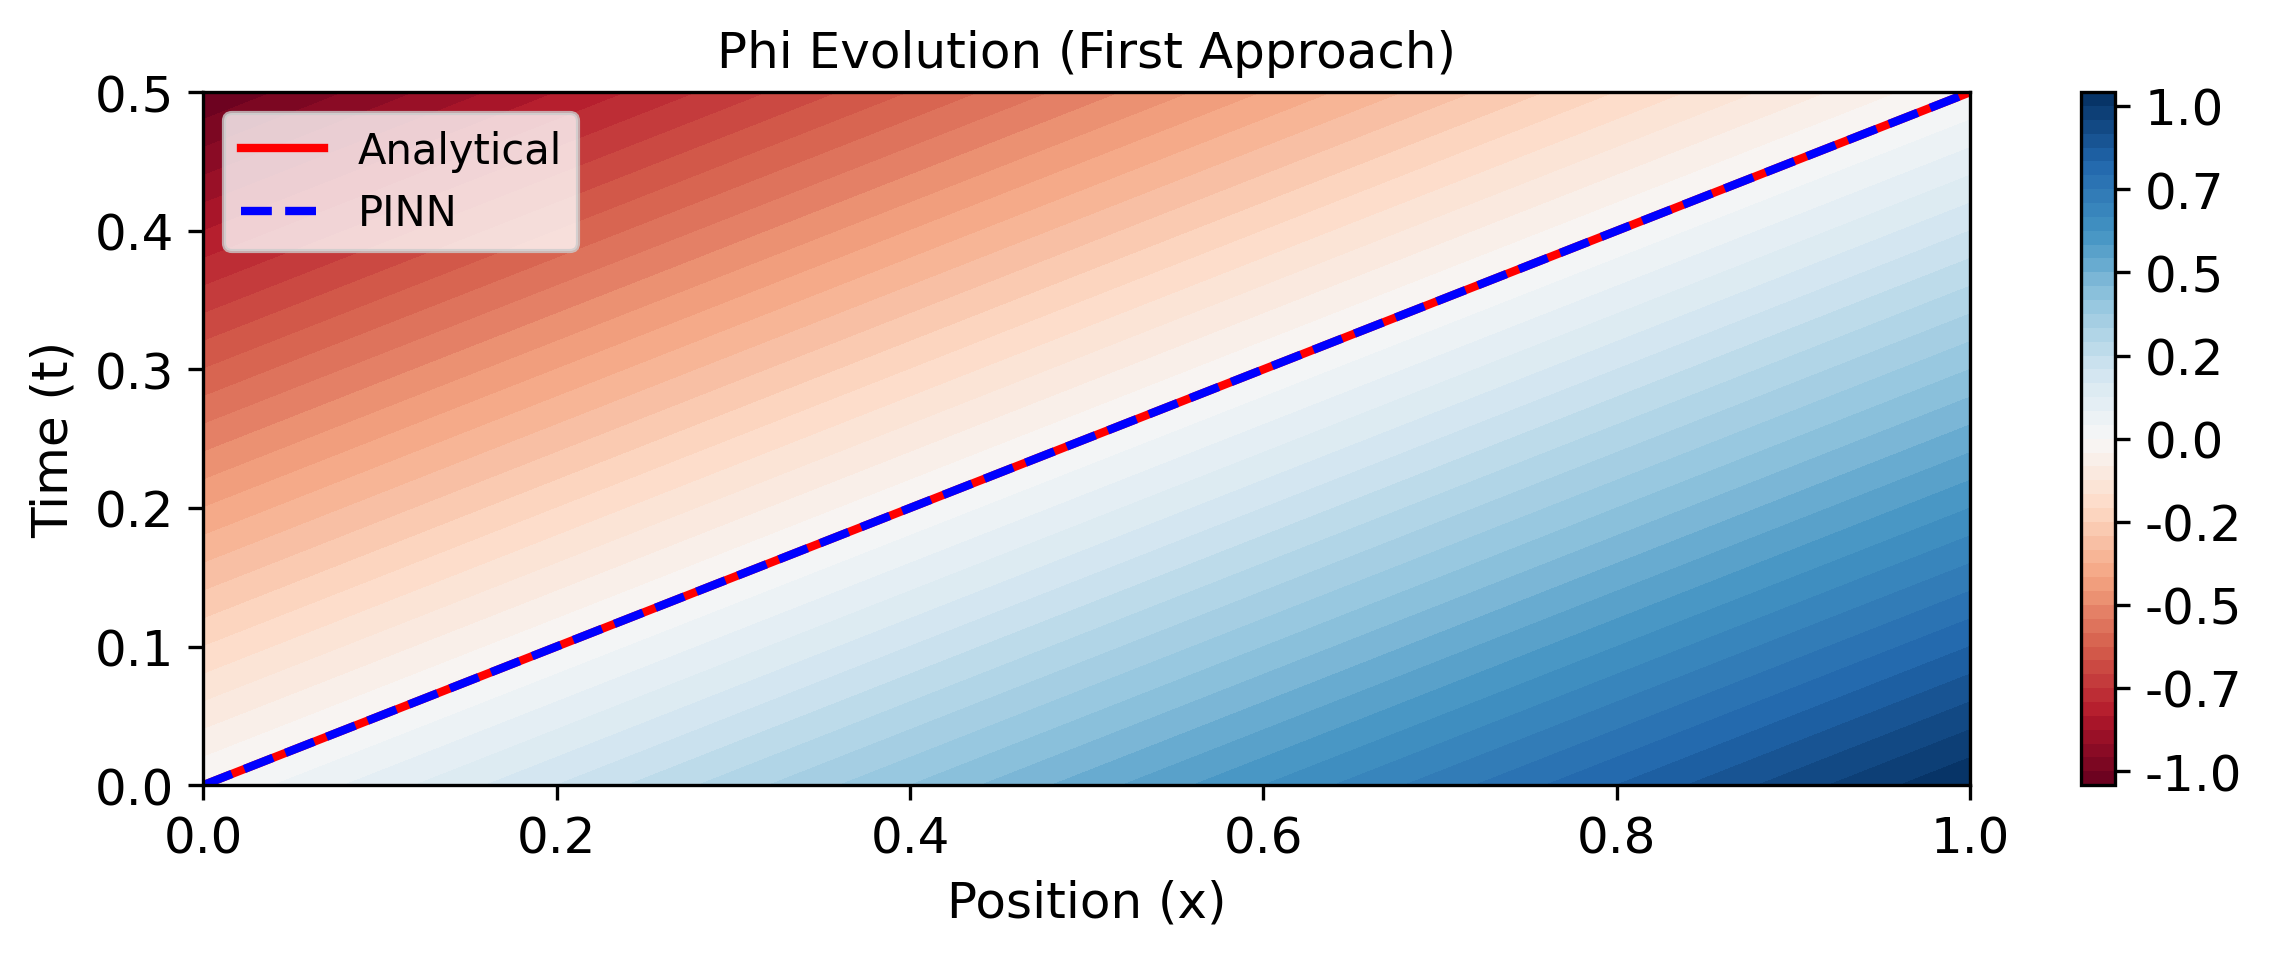

In [8]:
# Define the figure size and resolution
plt.figure(figsize=[9.5, 3])

# Calculate max absolute value of phi for color normalization
max_abs_phi = abs(phi_values).max()

# Plot the contour map
contour = plt.contourf(x_eval.numpy().flatten(), t_eval.numpy().flatten(), phi_values.T, 50, cmap='RdBu', vmin=-max_abs_phi, vmax=max_abs_phi)
plt.colorbar(format='%.1f')  # Adjust formatting as needed

# Overlay the analytical solution
plt.plot(analytical_positions, t_eval.numpy(), 'r-', linewidth=2, label='Analytical')
# Overlay the flow front curve
plt.plot(flow_front_positions, t_eval.numpy().flatten(), 'b--', linewidth=2, label='PINN')

# Setting labels and title
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.title('Phi Evolution (First Approach)', fontsize=12)

# Adding legend with specified font size
plt.legend(fontsize=10)

plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/1D_LS/first_approach_phi.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

In [9]:
import os

# Define the directory and filename
save_dir = './Trained Models'
filename = '1D_Level_Set_First_Approach.pth'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Path where the model will be saved
save_path = os.path.join(save_dir, filename)

# Save the model state
torch.save(pinn.state_dict(), save_path)